In [1]:
import numpy as np
import pandas as pd
from typing import List 

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Initializing parameter by preivous code

symbol = "BTC/USDT"
feature_lags = []
train_length = 48
batch_size = 32
seed = 44


# Preprocessing data
### Steps: 
1. Preview the price_data downloaded from BNB API: "BTC:USDT_price_data.csv"
2. Define the get_data and get_target function prepare for data splitting 
3. Define the split_data function splitting data for Testing and Prediction
4. Adjust dataset prepare for stateful LSTM
5. Checking dataset

In [3]:
# Get data and pre-view
df = pd.read_csv("BTC:USDT_price_data.csv")
df

,BTC:USDT_timestamp,BTC:USDT_open,BTC:USDT_high,BTC:USDT_low,BTC:USDT_close,BTC:USDT_volume
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
51523,2023-11-10 07:00:00,36615.00,36696.64,36427.61,36439.98,2115.678290
51524,2023-11-10 08:00:00,36439.98,36525.14,36324.71,36516.30,1550.540620
51525,2023-11-10 09:00:00,36516.30,36564.25,36458.45,36553.19,1075.571040
51526,2023-11-10 10:00:00,36553.18,36750.00,36502.00,36750.00,1463.989210


### Define the target function

In [4]:
def add_regression_target(df: pd.DataFrame, symbol: str, days_to_forecast: int) -> pd.DataFrame:

    symbol = symbol.replace("/", ":")
    days_to_shift = days_to_forecast * 24
    df[f"{symbol}_target"] = (
        df[f"{symbol}_close"].pct_change(periods=days_to_shift).shift(-days_to_shift)
    )
    return df

### Define the get_features_and_target function
But, in LSTM the data only need "open", "high", "low", "close", and "volume" this fundamental data. So, the get_features_and_target function is simplied.


In [5]:
def get_features_and_target(
    symbol: str,
    feature_lags: List[int] = [3, 9, 16],
    days_to_forecast: int = 1,
    class_threshold=0.03,
    model_type="reg",
) -> pd.DataFrame:
    """
    Generates features and target variable for the given cryptocurrency symbol.

    :param symbol: The symbol for the cryptocurrency pair.
    :param feature_lags: List of integers representing the lags for feature generation.
    :param days_to_forecast: Number of days to forecast.
    :param model: ML or LSTM, changes how the target is encoded
    :return: DataFrame with features and target.
    """
    symbol = symbol.replace("/", ":")
    features_df = pd.read_csv(
        f"{symbol}_price_data.csv", parse_dates=True, index_col=f"{symbol}_timestamp"
    )

    required_columns = [
        f"{symbol}_close",
        f"{symbol}_high",
        f"{symbol}_low",
        f"{symbol}_volume",
    ]
    if not all(col in features_df.columns for col in required_columns):
        raise ValueError("Required columns are missing in the DataFrame")
    
    # Add target and handle missing values
    if model_type == "reg":
        features_df = add_regression_target(features_df, symbol, days_to_forecast)
    else:
        raise ValueError("not supported model")

    features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    features_df.dropna(inplace=True)

    return features_df
    


### Data splitting for Cross Validation and Prediction Testing 

The default splitting_size is set as 20%, which means the first spliiting provide train_data is 80% df, and test data is 20% df

The second spliiting provides training_data will be updataed to 80% training_data and remained 20% ready for vaild_data

In [6]:
def split_data(X, y, test_size=0.2, random_state=None):
    X_1, X_2, y_1, y_2 = train_test_split(
        X, 
        y, 
        test_size=test_size, 
        random_state=random_state)
    
    return X_1, X_2, y_1, y_2

### Get training data, test data, and validation data

In [7]:
df = get_features_and_target(
    symbol,
    days_to_forecast=1,
    feature_lags=feature_lags,
    model_type="reg")

symbol = symbol.replace("/", ":")
X = df.drop(columns=f"{symbol}_target")
y = df[f"{symbol}_target"].copy()


In [8]:
X_train, X_test, y_train, y_test = split_data(X,y)

In [9]:
X_train, X_valid, y_train, y_valid = split_data(X_train, y_train)

### Define the function to adjust dataset and prepare to LSTM


In [10]:
# Function to adjust dataset
def adjust_dataset(X, y, train_length, batch_size):
    total_sequences = len(X) - train_length + 1
    complete_batches = total_sequences // batch_size
    keep_sequences = complete_batches * batch_size
    keep_data_points = keep_sequences + train_length - 18

    X_adjusted = X.iloc[:keep_data_points]
    y_adjusted = y.iloc[train_length - 1 : keep_data_points]

    return X_adjusted, y_adjusted

In [11]:
# Adjusting training dataset
X_train_adjusted, y_train_adjusted = adjust_dataset(
    X_train, y_train, train_length, batch_size
)

# Adjusting validation dataset
X_valid_adjusted, y_valid_adjusted = adjust_dataset(
    X_valid, y_valid, train_length, batch_size
)

# Adjusting test dataset
X_test_adjusted, y_test_adjusted = adjust_dataset(
    X_test, y_test, train_length, batch_size
)


# Now, create the datasets
train_df_stateful = tf.keras.utils.timeseries_dataset_from_array(
    X_train_adjusted,
    targets=y_train_adjusted[(train_length - 1) :],
    sequence_length=train_length,
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
)

valid_df_stateful = tf.keras.utils.timeseries_dataset_from_array(
    X_valid_adjusted,
    targets=y_valid_adjusted[(train_length - 1) :],
    sequence_length=train_length,
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
)

test_df_stateful = tf.keras.utils.timeseries_dataset_from_array(
    X_test_adjusted,
    targets=y_test_adjusted[(train_length - 1) :],
    sequence_length=train_length,
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
)

In [12]:
# Check
# Initialize variables to hold the first batch's data
# Get the first batch from the dataset
for X_batch, y_batch in train_df_stateful.take(1):
    # Extract the first sample from the batch
    first_sample_features = X_batch[0][-1].numpy().tolist()
    first_sample_target = y_batch[0]

    # Print the feature vector and its corresponding target
    print("Feature Vector (First Sample):", first_sample_features)
    print("Target (First Sample):", first_sample_target)
    break  # Exit after processing the first batch

X_train_adjusted.iloc[47], y_train_adjusted[47]
y_train_adjusted

Feature Vector (First Sample): [13015.03, 13026.59, 12957.0, 12968.96, 2503.534752]
Target (First Sample): tf.Tensor(0.16296529934859727, shape=(), dtype=float64)


/var/folders/cf/sxjnb6290vg3_vl8r3g_zdp40000gn/T/ipykernel_85561/3107275784.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_train_adjusted.iloc[47], y_train_adjusted[47]


BTC:USDT_timestamp
2020-10-23 11:00:00    0.001692
2020-01-26 19:00:00    0.042364
2022-10-24 11:00:00   -0.006255
2017-12-02 23:00:00    0.025289
2023-04-06 10:00:00    0.002993
                         ...   
2021-01-12 04:00:00   -0.059618
2022-07-17 04:00:00    0.001968
2020-01-25 15:00:00    0.014940
2019-11-29 10:00:00    0.023054
2019-10-08 18:00:00    0.049618
Name: BTC:USDT_target, Length: 32879, dtype: float64

# LSTM model 

### Model design

In [13]:
tf.keras.backend.clear_session()

# Preperation of layers
conv1 = tf.keras.layers.Conv1D(
    filters=60,
    kernel_size=3,
    strides=1,
    padding="causal",
    activation="relu",
    input_shape=[None, len(df.columns) - 1])

# Bidirectional LSTM tf.keras.layers
lstm1 = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(30, return_sequences=True, stateful=False))
lstm2 = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(30, return_sequences=False, stateful=True))
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

# Model
inputs = tf.keras.layers.Input(batch_size=32, shape=(None, len(df.columns) - 1))
x = norm_layer(inputs)
x = conv1(x)
x = lstm1(x)

x = lstm2(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Increased dropout
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization
x = tf.keras.layers.Dense(
    30,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=regularizers.l2(0.01),
)(
    x
)  # L2 regularization on Dense layer
outputs = tf.keras.layers.Dense(1)(x)

# Optimizers and losses
SGD_optimizer = tf.keras.optimizers.legacy.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True
)
adam_opt = tf.keras.optimizers.AdamW(learning_rate=0.001)

huber_loss = tf.keras.losses.Huber()
mse_loss = "mse"

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss=mse_loss, metrics=["mae", "RootMeanSquaredError"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, None, 5)]           0         
                                                                 
 normalization (Normalizati  (32, None, 5)             11        
 on)                                                             
                                                                 
 conv1d (Conv1D)             (32, None, 60)            960       
                                                                 
 bidirectional (Bidirection  (32, None, 60)            21840     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (32, 60)                  21840     
 onal)                                                           
                                                             

### Callbacks and model fitting 

In [14]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3, monitor="val_mae", restore_best_weights=True
)
tensorboard = tf.keras.callbacks.TensorBoard("TB_regression_logs")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.5,  # Reduce learning rate by half
    patience=1,  # Number of epochs with no improvement
    min_lr=0.0001,  # Minimum learning rate
)
model.fit(
    train_df_stateful,
    validation_data=valid_df_stateful,
    callbacks=[early_stopping, tensorboard, reduce_lr],
    epochs=50,
)

Epoch 1/50
1026/1026 [==============================] - 20s 17ms/step - loss: 0.2639 - mae: 0.1004 - root_mean_squared_error: 0.1957 - val_loss: 0.0324 - val_mae: 0.0298 - val_root_mean_squared_error: 0.0428 - lr: 0.0010
Epoch 2/50
1026/1026 [==============================] - 17s 16ms/step - loss: 0.0086 - mae: 0.0279 - root_mean_squared_error: 0.0415 - val_loss: 0.0018 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0401 - lr: 0.0010
Epoch 3/50
1026/1026 [==============================] - 17s 17ms/step - loss: 0.0017 - mae: 0.0269 - root_mean_squared_error: 0.0407 - val_loss: 0.0016 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0401 - lr: 0.0010
Epoch 4/50
1026/1026 [==============================] - 17s 17ms/step - loss: 0.0017 - mae: 0.0269 - root_mean_squared_error: 0.0407 - val_loss: 0.0016 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0401 - lr: 5.0000e-04
Epoch 5/50
1026/1026 [==============================] - 17s 17ms/step - loss: 0.0017 - mae: 0.0269 - root_mean_s

### Making prediction by testing dataset and calculate the accuracy rate

In [15]:
y_pred = model.predict(test_df_stateful)
y_pred.shape

318/318 [==============================] - 2s 5ms/step


(10176, 1)

In [16]:
y_pred

array([[0.00190558],
       [0.00125205],
       [0.00123965],
       ...,
       [0.00119241],
       [0.00122497],
       [0.00090299]], dtype=float32)

In [17]:
y_test.shape

(10301,)

In [18]:
y_test_values = y_test.values
y_test_values

array([ 0.00433237, -0.00816381,  0.04932601, ..., -0.00697353,
       -0.02391556, -0.00145457])

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

ValueError: Found input variables with inconsistent numbers of samples: [10301, 10176]

### Plot the prediction 


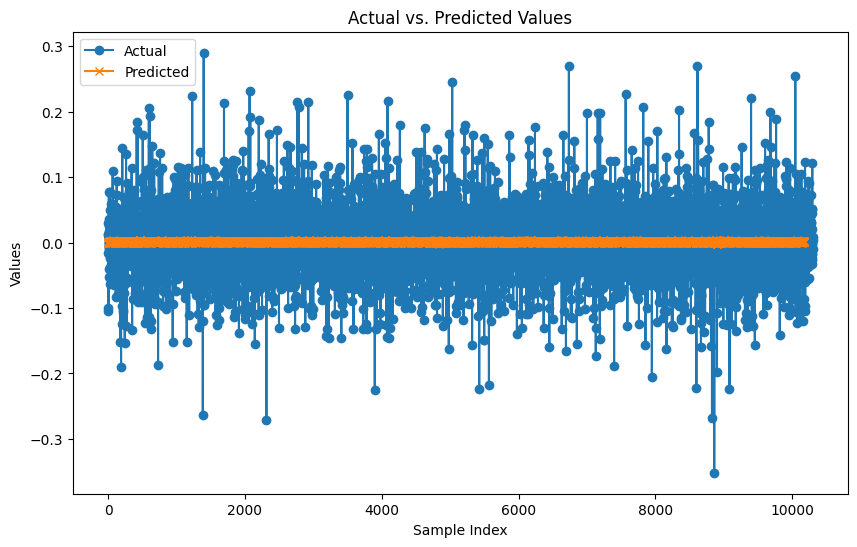

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual', marker='o')
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', marker='x')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()


### Calculate the accumulated return 

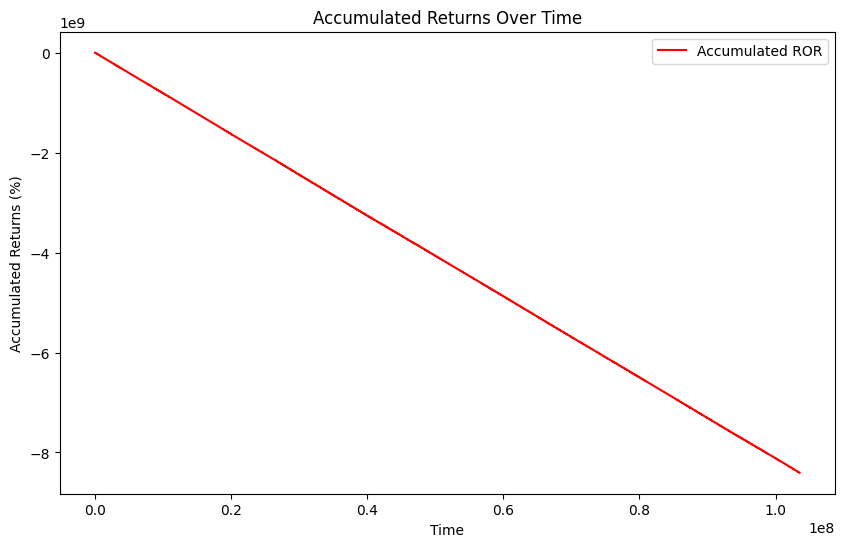

In [20]:
# Extract the numeric values from the second the value
## Because the prediction is made for the next shift value 
y_test_values = y_test.values[1:]

# Adjust the lengths to be the same
min_length = min(len(y_test_values), len(y_pred))
y_test_values = y_test_values[:min_length]
y_pred_values = y_pred[:min_length]


# Assuming y_pred has the same length as y_test
predicted_ROR = (y_pred_values[1:] - y_test_values[:-1]) / y_test_values[:-1] * 100


# Calculate accumulated returns
cumulative_predicted_returns = np.cumsum(predicted_ROR)


# Plot the accumulated returns
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cumulative_predicted_returns)), cumulative_predicted_returns, label='Accumulated ROR', color = 'red')

plt.title('Accumulated Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Accumulated Returns (%)')
plt.legend()
plt.show()

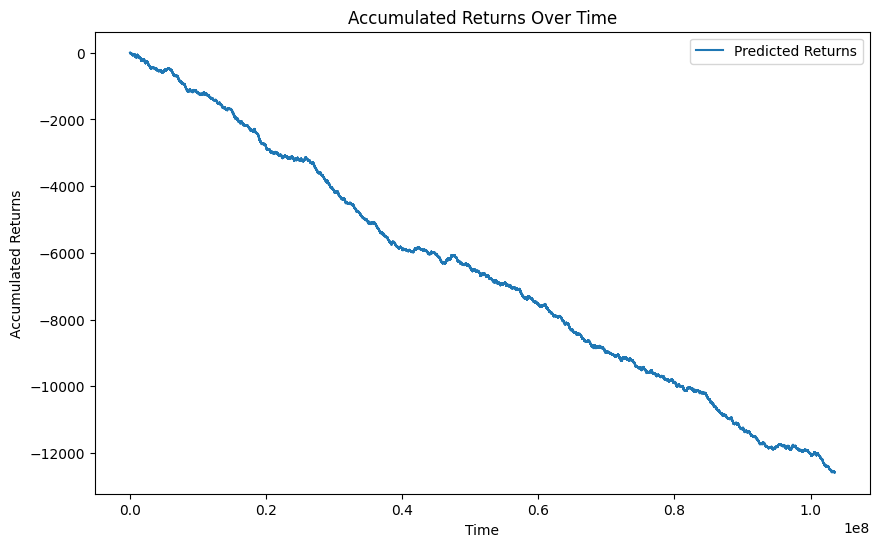

In [21]:

# Extract the numeric values
y_test_values = y_test.values[1:]  # Exclude the first value

# Adjust the lengths to be the same
min_length = min(len(y_test_values), len(y_pred))
y_test_values = y_test_values[:min_length]
y_pred_values = y_pred[:min_length]

# Calculate actual returns based on actual prices (y_test)
# actual_returns = y_test_values[1:] - y_test_values[:-1]

# Assuming y_pred_values has the same length as y_test_values
predicted_returns = y_pred_values[1:] - y_test_values[:-1]

# Calculate accumulated returns
# cumulative_actual_returns = np.cumsum(actual_returns)
cumulative_predicted_returns = np.cumsum(predicted_returns)

# Plot the accumulated returns
plt.figure(figsize=(10, 6))
# plt.plot(np.arange(len(cumulative_actual_returns)), cumulative_actual_returns, label='Actual Returns')
plt.plot(np.arange(len(cumulative_predicted_returns)), cumulative_predicted_returns, label='Predicted Returns')

plt.title('Accumulated Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Accumulated Returns')
plt.legend()
plt.show()
